## A
### Introduction
嗯嗯.

### Libraries & Settings

In [7]:
import os
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data
#### Data Preparation

In [15]:
train_data_percentage = 0.8
train_data_path = 'train_data.csv'
test_data_path = 'test_data.csv'

if os.path.exists(train_data_path) and os.path.exists(test_data_path):
    dataset_train = pd.read_csv(train_data_path)
    dataset_test = pd.read_csv(test_data_path)
else:
    # Parameters & Functions
    selected_country_codes = ['GBR', 'FRA', 'DEU', 'ITA', 'NLD', 'NOR', 'SWE', 'FIN', 'DNK', 'ISL', 'CHE', 'BEL', 'LUX', 'IRL', 'ESP', 'PRT', 'AUT', 'CZE', 'SVK', 'HUN', 'GRC', 'SVN', 'POL', 'EST', 'LVA', 'LTU', 'MLT', 'CYP'] # , 'SMR'
    selected_year_codes = list(map(str, range(2010, 2023 + 1)))

    def select_dataframe(data_frame):
        return data_frame[data_frame['Country Code'].isin(selected_country_codes)].iloc[:, :-1].reset_index(drop = True)

    def organize_dataframe(data_frame, value_name):
        res = pd.melt(data_frame, id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name = 'Year Code', value_name = value_name)[['Country Code', 'Year Code', value_name]]
        res[value_name] = res.groupby('Country Code')[value_name].ffill().bfill()
        return res[res['Year Code'].isin(selected_year_codes)]

    # Load .csv files
    csv_path = '../data/'

    alcohol_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'alcohol_consumption_per_capita.csv'))) # Liter of pure alcohol per capita
    alcohol_male_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'alcohol_consumption_per_capita_male.csv'))) # Liter of pure alcohol per capita, male
    alcohol_female_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'alcohol_consumption_per_capita_female.csv'))) # Liter of pure alcohol per capita, female
    tobacco_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'prevalence_of_current_tobacco_use.csv'))) # % of adults
    tobacco_male_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'prevalence_of_current_tobacco_use_male.csv'))) # % of male adults
    tobacco_female_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'prevalence_of_current_tobacco_use_female.csv'))) # % of female adults

    diabetes_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'diabetes_prevalence.csv'))) # % of population ages 20 to 79
    tuberculosis_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'incidence_of_tuberculosis.csv'))) # per 100,000 people
    mortality_specified_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'mortality_from_CVD_cancer_diabetes_CRD.csv'))) # % of population ages 30 and 70
    mortality_specified_male_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'mortality_from_CVD_cancer_diabetes_CRD_male.csv'))) # % of male population ages 30 and 70
    mortality_specified_female_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'mortality_from_CVD_cancer_diabetes_CRD_female.csv'))) # % of female population ages 30 and 70

    # Organize data
    alcohol_df = organize_dataframe(alcohol_csv, 'alcohol') # Alcohol Consumption
    merged_df = alcohol_df

    alcohol_male_df = organize_dataframe(alcohol_male_csv, 'alcohol_m') # Alcohol Consumption (M)
    merged_df = pd.merge(merged_df, alcohol_male_df, on = ['Country Code', 'Year Code'], how = 'outer')

    alcohol_female_df = organize_dataframe(alcohol_female_csv, 'alcohol_f') # Alcohol Consumption (F)
    merged_df = pd.merge(merged_df, alcohol_female_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tobacco_df = organize_dataframe(tobacco_csv, 'tobacco') # Tobacco Use
    merged_df = pd.merge(merged_df, tobacco_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tobacco_male_df = organize_dataframe(tobacco_male_csv, 'tobacco_m') # Tobacco Use (M)
    merged_df = pd.merge(merged_df, tobacco_male_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tobacco_female_df = organize_dataframe(tobacco_female_csv, 'tobacco_f') # Tobacco Use (F)
    merged_df = pd.merge(merged_df, tobacco_female_df, on = ['Country Code', 'Year Code'], how = 'outer')

    diabetes_df = organize_dataframe(diabetes_csv, 'diabetes') # Diabetes Prevalence
    merged_df = pd.merge(merged_df, diabetes_df, on = ['Country Code', 'Year Code'], how = 'outer')
    diabetes_df.to_csv('diabetes.csv', index = False)

    tuberculosis_df = organize_dataframe(tuberculosis_csv, 'tuberculosis') # Tuberculosis Incidence
    merged_df = pd.merge(merged_df, tuberculosis_df, on = ['Country Code', 'Year Code'], how = 'outer')

    mortality_specified_df = organize_dataframe(mortality_specified_csv, 'mortality') # Mortality (Specified Types)
    merged_df = pd.merge(merged_df, mortality_specified_df, on = ['Country Code', 'Year Code'], how = 'outer')

    mortality_specified_male_df = organize_dataframe(mortality_specified_male_csv, 'mortality_m') # Mortality (Specified Types, M)
    merged_df = pd.merge(merged_df, mortality_specified_male_df, on = ['Country Code', 'Year Code'], how = 'outer')

    mortality_specified_female_df = organize_dataframe(mortality_specified_female_csv, 'mortality_f') # Mortality (Specified Types, F)
    merged_df = pd.merge(merged_df, mortality_specified_female_df, on = ['Country Code', 'Year Code'], how = 'outer')

    merged_df = merged_df.drop(columns = ['Country Code', 'Year Code']).dropna().reset_index(drop = True)
    
    # Divide into train and test data
    dataset_train, dataset_test = train_test_split(merged_df, test_size = 1 - train_data_percentage, random_state = 42)
    dataset_train = dataset_train.reset_index(drop = True)
    dataset_test = dataset_test.reset_index(drop = True)
    dataset_train.to_csv(train_data_path, index = False)
    dataset_test.to_csv(test_data_path, index = False)

# print(dataset_train)
# print(dataset_test)

#### Understanding the Data
##### Correlation Matrix

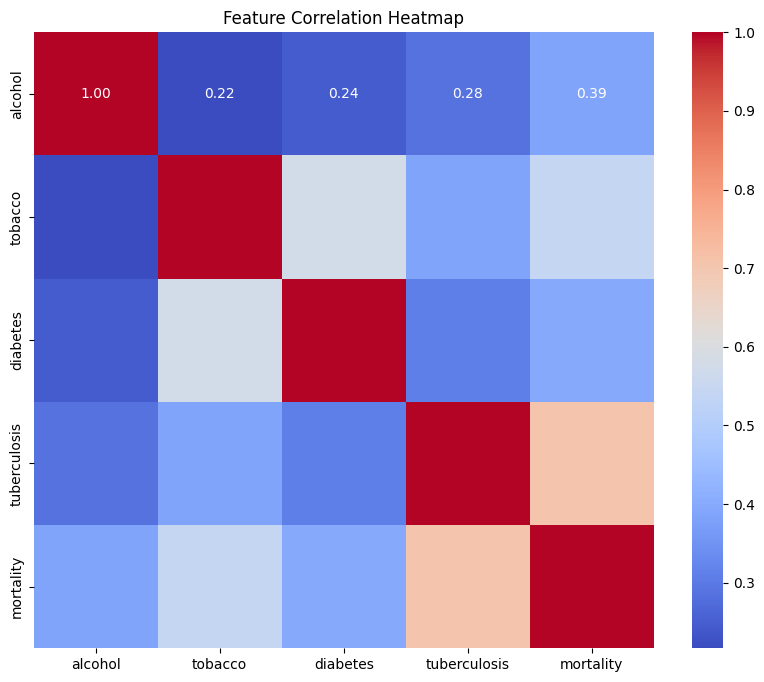

In [13]:
plt.figure(figsize = (10, 8))
sns.heatmap(dataset_train.drop(columns = ['alcohol_m', 'alcohol_f', 'tobacco_m', 'tobacco_f', 'mortality_m', 'mortality_f']).corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

##### Pairplot

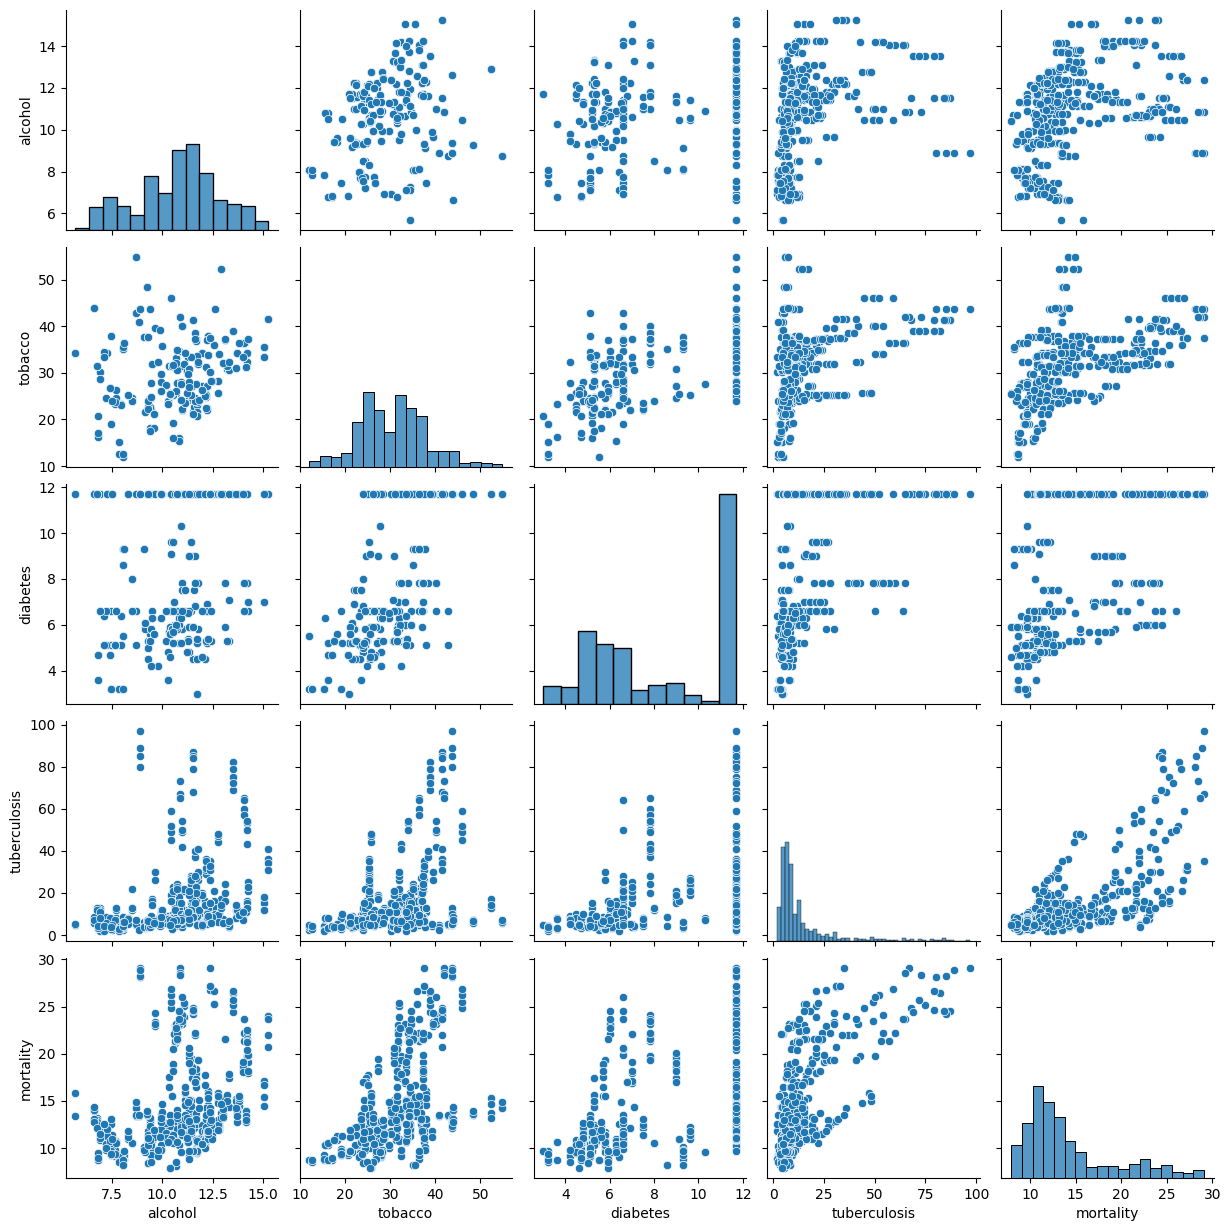

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category = Warning)

    sns.pairplot(dataset_train.drop(columns = ['alcohol_m', 'alcohol_f', 'tobacco_m', 'tobacco_f', 'mortality_m', 'mortality_f']))
    plt.show()

### Modeling
嗯嗯.

#### Model 1
嗯嗯.

### Analysis